This document describes the bid and response stratgies for various device types in TESS.

#### Revision history

| Date        | Author           | Remarks
| ----------- | ---------------- | -------
| 11 Mar 2020 | David P. Chassin | Initial draft

# 1. Price Response

Bid/response strategies require information from the market about future prices. The required values are denoted, $P_{exp}$ and $P_{dev}$, the expected price and the expected standard deviation, respectively, for the upcoming market interval. 

The ideal market interval, $t_s$, is based on the natural time-constant of the fastest acting device.   A good rule of thumb to determine the market interval is to sample the states at about 10 times the fastest acting device's time constant. In homes, HVAC systems typically have the lowest time-constant, which is on the order of 1 hour.  Therefore the market interval $t_s=5$ minutes.  

Generally speaking the dominant mode in transactive system is the diurnal (day/night) cycle.  In the absense of forward prices, the expected and variance are calculated from historical data using the last 24 hours of price data, i.e.,

$$ \tag{1.1}
    P_{exp}(N) = \frac{1}{N} \sum_{t=-N}^{-1} P_t
$$

and

$$ \tag{1.2}
    P_{dev}(N) = \sqrt{\frac{1}{N-1} \sum_{t=-N}^{-1} [P_t-P_{exp}(N)]^2 }
$$

where $N=288$ for a 24-hour history of 5-minute market intervals.

#### Table 1.1: Price Response Data

| Variable | Format | Unit       | Range    | Source
| -------- | ------ | ---------- | -------- | --------------------
| Pt       | +10.4f | tokens/MWh | (0,+inf( | Market clearing data
| N        | u      | -          | (0,+inf( | Market configuration      

### Example 1.1

The following example illustrates obtaining the price history, computing the expectation and deviation price, and obtaining the clearing price.

Table 1.2: Price data

Variable   Value    Unit
-------- ---------- ----------
Pexp       +50.0087 tokens/MWh
Pdev        +4.7840 tokens/MWh
Pclear     +56.6204 tokens/MWh


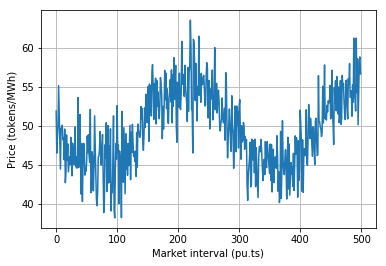

Figure 1.1: Price history


In [7]:
from agents import *
from matplotlib.pyplot import *

data = get_price_history(source='random',Pexp=50,Pdev=5,N=500,noise=1)
expect = get_price_expectation(data)
Pexp = expect["mean"]
Pdev = expect["std"]
Pclear = get_clearing_price(data)

print("Table 1.2: Price data")
print("=====================\n")
print("Variable   Value    Unit")
print("-------- ---------- ----------")
print("Pexp     %+10.4f tokens/MWh" % Pexp)
print("Pdev     %+10.4f tokens/MWh" % Pdev)
print("Pclear   %+10.4f tokens/MWh" % Pclear)

plot(data)
xlabel('Market interval (pu.ts)')
ylabel('Price (tokens/MWh)')
grid()
show()
print("Figure 1.1: Price history")


----
# 2. HVAC

For each occupancy mode, thermostatic devices depend on four user preference inputs, denoted $T_{des}$, $T_{min}$, $T_{max}$, and $K_{hvac}$ to convert temperatures to bid, and prices to bids. 

Reference: https://www.osti.gov/biblio/926113

#### Table 2.1: HVAC User Preference Inputs (for each occupancy mode)

| Name  | Optional | Default | Minimum | Maximum  | Definition
| ----- | -------- | ------- | ------- | -------- | ----------
| Tdes  | No       | 72 degF | 55 degF | 95 degF  | Desired indoor air temperature
| Tmin  | No       | Tdes-5  | 50 degF | 90 degF  | Minimum allowed temperature
| Tmax  | No       | Tdes+5  | 60 degF | 100 degF | Maximum allowed temperature
| Khvac | No       | 1.0     | 0.0     | +inf     | Savings setting

### Example 2.1

The following sets the user preferences for the remaining examples in this document.

In [2]:
Tdes = 72.0
Tmin = Tdes - 2.0
Tmax = Tdes + 5.0
Khvac = 1.0

print("Table 2.2: User preferences")
print("===========================\n")
print("Variable Value Unit")
print("-------- ----- ----")
print("Tdes     %5.1f degF" % Tdes)
print("Tmin     %5.1f degF" % Tmin)
print("Tmin     %5.1f degF" % Tmin)
print("Khvac    %5.1f" % Khvac)

Table 2.2: User preferences

Variable Value Unit
-------- ----- ----
Tdes      72.0 degF
Tmin      70.0 degF
Tmin      70.0 degF
Khvac      1.0


## 2.1 HVAC Bid

In the absence of forward prices, an HVAC agent computes the bid price when $mode\ne0$ as follows

$$ \tag{2.1}
    P_{bid} = P_{exp} - 3 \mathrm{sign}(m) P_{dev} \frac{T_{obs}-T_{des}}{|T_{ref}-T_{des}|} 
$$

where 

$$ \tag{2.2}
    T_{ref} = \left\{ \begin{array}{lll}
        T_{min} & : & T_{obs} \le T_{des}
    \\
        T_{max} & : & T_{obs} \gt T_{des},
    \end{array} \right.
$$

$mode\in\{-1,0,+1,+2\}$ is the system mode ($-1$=cooling, $0$=off, $+1$=heating, $+2$=auxiliary), and $T_{obs}$ is the measured indoor air temperature.

The bid quantity when $mode\ne0$ is computed as follows

$$ \tag{2.3}
    Q_{bid} = \left\{ \begin{array}{lll}
        \bar{Q}_{cool} & : & mode = -1
    \\
        \bar{Q}_{heat} & : & mode = +1
    \\
        \bar{Q}_{aux} & : & mode = +2 \text{ and } T_{obs} < T_{min}
    \end{array} \right.
$$

where $\bar{Q}_{mode}$ is the average power for the mode selected.

When $mode=0$ no HVAC bid is submitted.

### Table 2.3: HVAC Bid Inputs

| Variable | Format | Unit  | Range       | Source            |
| -------- | ------ | ----- | ----------- | ----------------- |
| mode     | d      | -     | {-1,0,1,-2} | Device controller |
| Tobs     | g      | MW    | (0,+inf(    | Device controller |
| Qcool    | g      | MW    | (0,+inf(    | Device telemetry  |
| Qheat    | g      | MW    | (0,+inf(    | Device telemetry  |
| Qaux     | g      | MW    | (0,+inf(    | Device telemetry  |

### Example 2.2

The following example plots the HVAC price bids for heating and cooling mode.

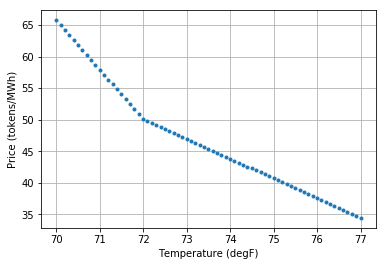

Figure 2.1: Heating bid curve


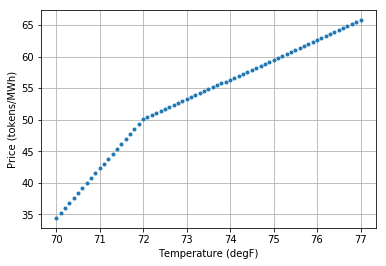

Figure 2.2: Cooling bid curve


In [3]:
Trange = np.arange(start=Tmin,stop=Tmax+0.05,step=0.1)
Qmode = [10];

Prange = list(map(lambda Tobs:get_hvac_bid(Pexp,Pdev,1,Tobs,Tdes,Tmin,Tmax,Khvac,Qmode)["offer"],Trange))
plot(Trange,Prange,'.')
xlabel('Temperature (degF)')
ylabel('Price (tokens/MWh)')
grid()
show()
print("Figure 2.1: Heating bid curve")

Prange = list(map(lambda Tobs:get_hvac_bid(Pexp,Pdev,-1,Tobs,Tdes,Tmin,Tmax,Khvac,Qmode)["offer"],Trange))
plot(Trange,Prange,'.')
xlabel('Temperature (degF)')
ylabel('Price (tokens/MWh)')
grid()
show()
print("Figure 2.2: Cooling bid curve")

## 2.2 HVAC Response

In the absence of forward prices, an HVAC agent computes mode as follows:

$$ \tag{2.4}
    mode = \left\{ \begin{array}{lll}
        mode & : & P_{clear} \le P_{bid}
    \\
        0 & : & P_{clear} \gt P_{bid}.
    \end{array} \right.
$$

Reference: https://www.osti.gov/biblio/926113

#### Table 2.4: HVAC Agent Inputs

| Variable | Format | Unit       | Range    | Source      |
| -------- | ------ | ---------- | -------- | ----------- |
| Pbid     | +10.4f | tokens/MWh | (0,+inf( | Market data |
| Pclear   | +10.4f | tokens/MWh | (0,+inf( | Market data |

----
# 3. Waterheater

Heat pump waters do not provide temperature readings, so it is not possible to estimate the state-of-charge of the waterheater from the available data.  Consequently, the bidding strategy for the waterheater requires an expected duty cycle $D_{exp}$ based on user preferences according to occupancy. 

There are two types of waterheaters TESS can control.  Standard waterheaters use thermomechanical controllers that are interrupted by the agent when the offer fails to clear the market. Standard waterheaters use a normally open interrupt relay, and the agent measures the voltage across the open relay to determine whether there is demand.  If the voltage is non-zero, a bid is submitted. If the bid clears the market, then the relay is closed.

Heat-pump waterheaters use digital controller.  Interrupting power also shuts off the controller. Thus the startup time may be non-trivial.  Heat-pump waterheaters use a normally closed relay, and the current is measured.  If the current is non-trivial, a bid is submitted and if the bid fails to clear the market, the relay is opened.

## 3.1 Waterheater Bid

If there is demand, i.e., voltage or current is non-zero, then the bid price is computed as follows:

$$
    P_{bid} = P_{exp} + 3 K_{hw} P_{dev} ( 2 D_{exp} - 1 ) 
$$

where $K_{hw}$ is the savings setting, $t_s$ is the market interval (e.g., 5 minutes), $Q_{on}$ is the measured waterheater power when on, $Q_{off}$ is the measured waterheater power when off, $Q_t$ is the observed waterheater demand at the time $t$, and 

$$
    D_{exp} = \left\{ \begin{array}{lll}
        D_{home} &:& home
    \\
        D_{work} &:& work
    \\
        D_{sleep} &:& sleep
    \\
        D_{away} &:& away
    \end{array} \right.
$$

is the expected duty cycle set by the consumer based on the occupancy schedule.

The bid quantity is based on the most recent non-trivial power measurement.

## 3.2 Waterheater Response

The waterheater interrupt relay status is computed as follows:

$$
    relay = \left\{ \begin{array}{lll}
        closed & : & P_{clear} \le P_{bid} 
    \\
        open & : & P_{clear} \gt P_{bid}
    \end{array} \right.
$$

#### Table 3.1: Waterheater Agent Inputs

| Variable  | Format | Unit       | Range                  | Source
| --------- | ------ | ---------- | ---------------------- | --------------------
| Dhome     | f      | -          | (0,1)                  | User preferences
| Dwork     | f      | -          | (0,1)                  | User preferences
| Daway     | f      | -          | (0,1)                  | User preferences
| Dsleep    | f      | -          | (0,1)                  | User preferences
| occupancy | s      | -          | {home,work,away,sleep} | Schedule
| Qt        | g      | MWh        | (0,+inf(               | Device measurements
| Qbid      | g      | MWh        | (0,+inf(               | Market bids
| Pbid      | +10.4f | tokens/MWh | (0,+inf(               | Market bids
| Pclear    | +10.4f | tokens/MWh | (0,+inf(               | Market clearing

### Example 3.1

The following example illustrates the waterheater bids for a range of expected duty cycles. (Note that a different history is generated for example sample, hence the variations in range over the domain.)

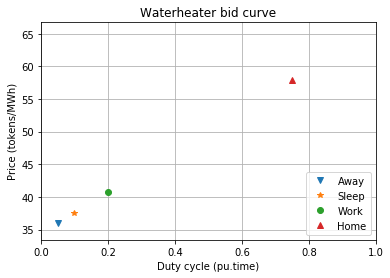

In [4]:
Drange = [0.05,0.10,0.20,0.75]
Lrange = ['Away','Sleep','Work','Home']
Trange = ['v','*','o','^']
Khw = 1.0
Qwh = 6.0
Prange = list(map(lambda Dexp:get_waterheater_bid(Pexp,Pdev,Dexp,Khw,Qwh)["offer"],Drange))
plt.figure()
for n in range(0,len(Drange)):
    plt.plot(Drange[n],Prange[n],Trange[n])
plt.legend(Lrange,loc=4)
plt.xlabel('Duty cycle (pu.time)')
plt.ylabel('Price (tokens/MWh)')
plt.xlim([0,1])
plt.ylim([Pexp-3*Pdev*Khw-1,Pexp+3*Pdev*Khw+1])
plt.title('Waterheater bid curve') 
plt.grid(); 
plt.savefig(f'test-fig{plt.get_fignums()[-1]}.png')

----
# 4. Photovoltaic

Rooftop PV are price takers. The bid zero and always operate if the price is non-negative.

## 4.1 Photovoltaic Bid

PV units bid

$$ \tag{4.1}
    P_{bid} = 0.0
$$

and

$$ \tag{4.2}
    Q_{ask} = -Q_{max}
$$

## 4.2 Photovoltaic Response

PV units always run when the price is non-negative

$$ \tag{4.3}
    Q_{set} = \left\{ \begin{array}{lll}
        Q_{ask} &:& P_{clear} \ge P_{bid}
    \\
        0.0 &:& P_{clear} \lt P_{bid}
    \end{array} \right. 
$$

where $Q_{set}$ is the power setpoint, and $Q_{bid}$ is the maximum available power.

#### Table 4.1: Photovoltaic Agent Inputs

| Variable | Format | Unit       | Range        | Source
| -------- | ------ | ---------- | ------------ | ------
| Qmax     | g      | MWh        | (0,$\infty$( | Device configuration
| Pbid     | +10.4f | tokens/MWh | (0,$\infty$( | Market bids
| Pclear   | +10.4f | tokens/MWh | (0,$\infty$( | Market clearing

# 5. Battery

The battery bid/response strategy seeks to maintain a user-specified target state-of-charge $E_{des}$. The value of $E_{des}$ may change over time, e.g., according to an occupancy schedule.  

Reference: https://ieeexplore.ieee.org/abstract/document/7427483

## 5.1 Battery Bid

The buy price is computed as

$$ \tag{5.1}
    P_{bid} = P_{exp} + 3 K_{es} P_{dev} \frac{E_{obs}-E_{des}}{|E_{ref}-E_{des}|} 
$$

where $E_{obs}$ is the current observed state of charge, and

$$ \tag{5.2}
    E_{ref} = \left\{ \begin{array}{lll}
        E_{min} & : & E_{obs} \le E_{des}
    \\
        E_{max} & : & E_{obs} \gt P_{des},
    \end{array} \right.
$$

with $E_{min}$ and $E_{max}$ as the minimum and maximum allowed state of charge, as specified by the user, but not to go outside the range $[0,E_{cap}]$, where $E_{cap}$ is the storage capacity of the battery.

The bid quantity is always $Q_{max}$.

The offer price is computed as

$$ \tag{5.3}
    P_{ask} = \frac{P_{oc}}{R_{es}}  + \frac{C_{es}}{(E_{des}+0.4)^2}
$$

where ${R_{es}}$ is the round-trip efficiency battery ageing factor, $C_{es}$ is the battery capital cost per unit energy capacity, $P_{oc}$ is the opportunity cost

$$ \tag{5.4}
    P_{oc} = P_{exp} + 3 K_{es} P_{dev} \frac{E_{obs}-E_{des}+Q_{max}t_s}{|E_{ref}-E_{des}-Q_{max}t_s|},
$$

and $Q_{max}$ is the maximum charging rate.

The offer quantity is always $-Q_{max}$.

## 5.2 Battery Response

The price response of the battery is

$$ \tag{5.5}
    Q_{set} = \left\{ \begin{array}{lll}
        -Q_{max} & : & P_{ask} \le P_{clear}
    \\
        0.0 & : & P_{ask} \lt P_{clear} \lt P_{bid}
    \\
        Q_{max} & : & P_{clear} \le P_{bid}
    \end{array} \right. 
$$

#### Table 5.1: Battery Agent Inputs

| Variable | Format | Unit      | Range        | Source
| -------- | ------ | --------- | ------------ | ------
| Kes      | f      | -         | )0,$\infty$( | User preferences
| Eobs     | f      | MWh       | (0,Emax)     | Device telemetry
| Edes     | f      | MWh       | (0,Emax)     | User settings
| Emin     | f      | MWh       | (0,Emax)     | Device configuration
| Emax     | f      | MWh       | (0,Emax)     | Device configuration
| Qmax     | f      | MW        | (0,$\infty$) | Device configuration
| Res      | f      | -         | )0,1(        | Device configuration
| Ces      | f      | tokens/MW | )0,$\infty$( | Device configuration
| ts       | f      | -         | )0,$\infty$( | Device configuration

#### Example 5.1

The following example illustrates the bid/ask curve of energy storage batteries.

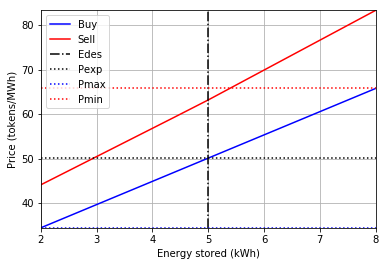

Figure 5.1: Battery buy/sell curve


In [5]:
Edes = 5.0
Emin = 2.0
Emax = 8.0
Qmax = 1.0
Kes = 1.0
ts = 1/12
Res = 0.8
Ces = 0.0
Erange = np.arange(Emin,Emax+0.001,(Emax-Emin)/10)

figure()
Pbuy = list(map(lambda Eobs: get_battery_bid(Pexp,Pdev,Eobs,Edes,Emin,Emax,Qmax,Kes)["offer"],Erange))
plot(Erange,Pbuy,'b')
Psell = list(map(lambda Eobs: get_battery_ask(Pexp,Pdev,Eobs,Edes,Emin,Emax,Qmax,Kes,ts,Res,Ces)["ask"],Erange))
plot(Erange,Psell,'r')
Pmin = Pexp-3*Pdev*Kes
Pmax = Pexp+3*Pdev*Kes
plot([Edes,Edes],[np.min(Pbuy),np.max(Psell)],'-.k',
     [Emin,Emax],[Pexp,Pexp],':k',
     [Emin,Emax],[Pmin,Pmin],':b',
     [Emin,Emax],[Pmax,Pmax],':r',)
grid()
xlabel('Energy stored (kWh)')
ylabel('Price (tokens/MWh)')
xlim([Emin,Emax])
ylim([np.min(Pbuy),np.max(Psell)])
legend(['Buy','Sell','Edes','Pexp','Pmax','Pmin'])

show()
print('Figure 5.1: Battery buy/sell curve')

# 6. EV Charger

EV chargers act like batteries except that they do not bid to sell at any price. In addition, the bid strategy for buying has a target time at which the desired battery charge is to be achieved.

Reference: https://ieeexplore.ieee.org/abstract/document/7427483

## 6.1 EV Charger Bid

The EV charger does not bid if the battery is fully charged.

The EV charger bid is given by

$$ \tag{6.1}
    P_{bid} = P_{exp} + 3 K_{ev} P_{dev} \left( 2 \frac{t_{req}}{t_{rem}} - 1 \right)
$$

where $K_{ev}$ is the user preference for charging strategy, $t_{req}$ is the time required to fully charge the battery, and $t_{rem}$ is the time remaining before the battery should be fully charged.

The higher the value the $K_{ev}$ the more likely the battery will be fully charged when the time $t_{rem}$ has elapsed.  

The time required to fully charge the battery is given by

$$ \tag{6.2}
    t_{req} = \frac{E_{max}-E_{est}}{Q_{max}}
$$

where $E_{est}$ is the estimated charge added to the battery (in kWh), $E_{max}$ is the maximum capacity of the battery (in kWh), and $Q_{max}$ is the maximum charge rate (in kW). If the battery $E_{est}$ cannot be measured directly, it must be computed from user input, e.g., as a percent of maximum charge or a fraction of the range in miles.

The available time is computed as the difference between the desired departure time $t_{dep}$ and the current time $t$

$$ \tag{6.3}
    t_{rem} = t_{dep} - t
$$

The desired departure time is a user input.

# 6.2 EV Charger Response

The EV response is

$$ \tag{6.4}
    Q_{set} = \left\{ \begin{array}{lll}
        P_{clear} \le P_{bid} & : & Q_{on}
    \\
        P_{clear} \gt P_{bid} & : & Q_{off}
    \end{array} \right.
$$

where $Q_{on}$ is the power when the charger is charging the battery, and $Q_{off}$ is the power when the charger is not charging the battery.

#### Table 6.1: EV Charger Agent Inputs

| Variable | Format | Unit   | Range        | Source
| -------- | ------ | ------ | ------------ | ------
| Kev      | f      | -      | (0,$\infty$( | User preferences
| Emax     | f      | kWh    | )0,$\infty$( | Device configuration
| Eest     | f      | kWh    | )0,Emax)     | User setting
| Qmax     | f      | kWh    | )0,$\infty$( | Device configuration
| tdes     | f      | s      | )0,$\infty$( | User setting

#### Example 6.1

The following example illustrate the bid prices as the EV battery is charged, and the fraction of time remaining required to reach full charge decreases.

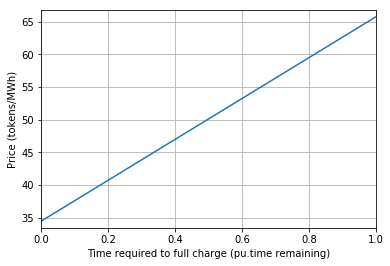

Figure 6.1: EV charger bid curve


In [6]:
trem = 1.0
trange = np.arange(0,trem+trem/20,trem/10)
Qev = 6.0
Kev = 1.0
Prange = list(map(lambda treq:get_evcharger_bid(Pexp,Pdev,Qev,Kev,treq,trem)["offer"],trange))
plt.figure()
plt.plot(trange,Prange)
plt.xlabel('Time required to full charge (pu.time remaining)')
plt.ylabel('Price (tokens/MWh)')
plt.xlim([0,trem])
plt.ylim([Pexp-3*Pdev*Kev-1,Pexp+3*Pdev*Kev+1])
plt.grid(); 
plt.show();
print('Figure 6.1: EV charger bid curve') 